In [1]:
from __future__ import division
from __future__ import print_function

import argparse

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
def load(path_list):
    load_data = (lambda path: librosa.load(path)[0])
    data = list(map(load_data, path_list))
    return data

In [7]:
def feature_extraction(data, dim):
    """
    wavファイルのリストから特徴抽出を行い，リストで返す
    扱う特徴量はMFCC13次元の平均（0次は含めない）
    Args:
        path_list: 特徴抽出するファイルのパスリスト
    Returns:
        features: 特徴量
    """
    features = np.array([np.mean(librosa.feature.mfcc(y=y, n_mfcc=dim), axis=1) for y in data])

    return features

In [4]:
training = pd.read_csv("../training.csv")
test = pd.read_csv("../test.csv")

In [5]:
# 学習データの読み込み
train_data = load("../" + training["path"].values)
test_data = load("../" + test["path"].values)

In [10]:
dim_acc = []
for d in range(12, 25):
    print(f"dim = {d}")
    X_train = feature_extraction(train_data, d)
    X_test = feature_extraction(test_data, d)
    Y_train = np.array(training["label"])
    
    # 学習データを学習データとバリデーションデータに分割 (バリデーションセットを20%とした例)
    X_train, X_valid, Y_train, Y_valid = train_test_split(
        X_train, Y_train,
        test_size=0.2,
        random_state=20200616,
    )
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)

    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(np.array(Y_train)).long()
    x_valid = torch.from_numpy(x_valid).float()
    y_valid = torch.from_numpy(np.array(Y_valid)).long()

    train_dataset = TensorDataset(x_train, y_train)
    valid_dataset = TensorDataset(x_valid, y_valid)
    
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    class Net(nn.Module):    
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(d, 255)
            self.fc2 = nn.Linear(255, 255)
            # self.fc3 = nn.Linear(255, 255)
            self.fc3 = nn.Linear(255, 10)
            # self.dropout1 = nn.Dropout2d(0.2)
            # self.dropout2 = nn.Dropout2d(0.2)
            # self.dropout3 = nn.Dropout2d(0.2)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            # x = self.dropout1(x)
            x = F.relu(self.fc2(x))
            # x = self.dropout2(x)
            # x = F.relu(self.fc3(x))
            # x = self.dropout3(x)
            x = F.softmax(self.fc3(x), dim=1)
            return x
        
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = Net().to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01)
    epochs = 100
    
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
 
    for epoch in range(epochs):
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

        net.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            acc = (outputs.max(1)[1] == labels).sum()
            train_acc += acc.item()
            loss.backward()      
            optimizer.step()
            avg_train_loss = train_loss / len(train_loader.dataset)
            avg_train_acc = train_acc / len(train_loader.dataset)

        net.eval()
        with torch.no_grad():
          for inputs, labels in valid_loader:        
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              acc = (outputs.max(1)[1] == labels).sum()
              val_acc += acc.item()
        avg_val_loss = val_loss / len(valid_loader.dataset)
        avg_val_acc = val_acc / len(valid_loader.dataset)
        
        #print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   #.format(epoch+1, epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
 
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
    print(val_acc_list[-1])
    dim_acc.append(val_acc_list[-1])

dim = 12
0.8351851851851851
dim = 13
0.8
dim = 14
0.8796296296296297
dim = 15
0.8759259259259259
dim = 16
0.912962962962963
dim = 17
0.9111111111111111
dim = 18
0.9333333333333333
dim = 19
0.9481481481481482
dim = 20
0.9425925925925925
dim = 21
0.9462962962962963
dim = 22
0.9351851851851852
dim = 23
0.9481481481481482
dim = 24
0.9462962962962963


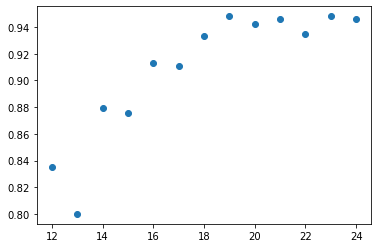

In [13]:
plt.scatter([i for i in range(12, 25)], dim_acc)